# U-Net: Convolutional Networks for Biomedical Image Segmentation (2015)
### Image segementation using Unet - PyTorch

In [1]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from os import walk
from pathlib import Path
import random
import glob

import torchvision
from torch import nn
from torch.nn import functional as F
from tqdm.notebook import tqdm

from PIL import Image
from torchvision.transforms import v2
from sklearn.model_selection import train_test_split
#from torchvision import datapoints

from functools import reduce
import itertools
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
from collections import defaultdict
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy

import torch
import torch.nn as nn
from torchvision import models
from torch.nn.functional import relu
from mpl_toolkits.axes_grid1 import make_axes_locatable
torchvision.disable_beta_transforms_warning()
from torchvision import tv_tensors
#torchvision.__version__

## Loading the Dataset/Data Preprocessing

In [2]:
#image_folder = "/g/data/wb00/admin/testing/Satellite Images of Water Bodies/Water Bodies Dataset/Images/"
#mask_folder  = "/g/data/wb00/admin/testing/Satellite Images of Water Bodies/Water Bodies Dataset/Masks/"
data_dir = "/g/data/wb00/admin/testing/Satellite Images of Water Bodies/Water Bodies Dataset" 
image_folder = f"{data_dir}/Images/"
mask_folder  = f"{data_dir}/Masks/"
image_names     = [ filenames for (dirpath, dirnames, filenames) in walk(image_folder)][0]
all_image_names = [ filenames for (dirpath, dirnames, filenames) in walk(image_folder)][0]

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, image_names, image_folder, mask_folder, transform):
        self.image_names  = image_names
        self.image_folder = image_folder
        self.mask_folder = mask_folder
        self.transform   = transform

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        im_name = self.image_names[idx]
        image_path = os.path.join(self.image_folder, im_name)
        mask_path  = os.path.join(self.mask_folder,  im_name)
        image = Image.open(image_path).convert('RGB')
        mask  = Image.open(mask_path).convert('L')  

        image = np.array(image, dtype=np.float32)
        mask  = np.array(mask,  dtype=np.float32)                                   
        image = image / 255.0                        
        mask  = mask  / 255.0  

        image = torch.from_numpy(image).permute(2, 0, 1)
        mask  = torch.from_numpy(mask).unsqueeze(0)       
        
        if self.transform:
            #image = datapoints.Image(image)
            #mask  = datapoints.Mask(mask)             
            image = tv_tensors.Image(image)
            mask  = tv_tensors.Mask(mask) 
            image, mask = self.transform (image, mask)
        
        image = v2.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]) (image)
        return im_name, image, mask

In [5]:
train_images, test_images = train_test_split(image_names, test_size=0.2, random_state=42)
test_images, val_images = train_test_split(test_images, test_size=0.5, random_state=42)

<BarContainer object of 3 artists>

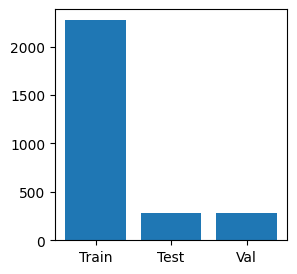

In [6]:
dataset_sizes = [len(train_images), len(test_images), len(val_images)]
labels = ["Train", "Test", "Val"]

from matplotlib.pyplot import figure
figure(figsize=(3, 3))
plt.bar(labels, dataset_sizes)

In [7]:
train_transform =v2.Compose([   
    #v2.PILToTensor(),
    #v2.ToTensor(),  
    #v2.ToDtype(torch.float32),
    #v2.Resize([256, 256]),
    v2.RandomHorizontalFlip(),
    v2.RandomVerticalFlip(),
    v2.Resize([256, 256]),
])

val_transform = v2.Compose([    
    #v2.ToTensor(),  
    #v2.Resize([256, 256]), 
    v2.RandomHorizontalFlip(),  
    v2.RandomVerticalFlip(), 
    v2.Resize([256, 256]), 
])

test_transform = v2.Compose([
    #v2.ToTensor(),
    v2.Resize([256, 256]),
])

trainset = Dataset(train_images, image_folder, mask_folder, transform = train_transform)
testset  = Dataset(test_images,  image_folder, mask_folder, transform = test_transform)
valset   = Dataset(val_images,   image_folder, mask_folder, transform = val_transform)

In [8]:
train_batch_size = 32
val_batch_size   = 32
test_batch_size  = 16

trainloader = torch.utils.data.DataLoader(trainset, batch_size= train_batch_size, num_workers= 2, shuffle= True)
valloader   = torch.utils.data.DataLoader(valset, batch_size= val_batch_size, num_workers= 2, shuffle= True)
testloader  = torch.utils.data.DataLoader(testset, batch_size= test_batch_size, num_workers= 2, shuffle= True)

## plotting images and mask labels

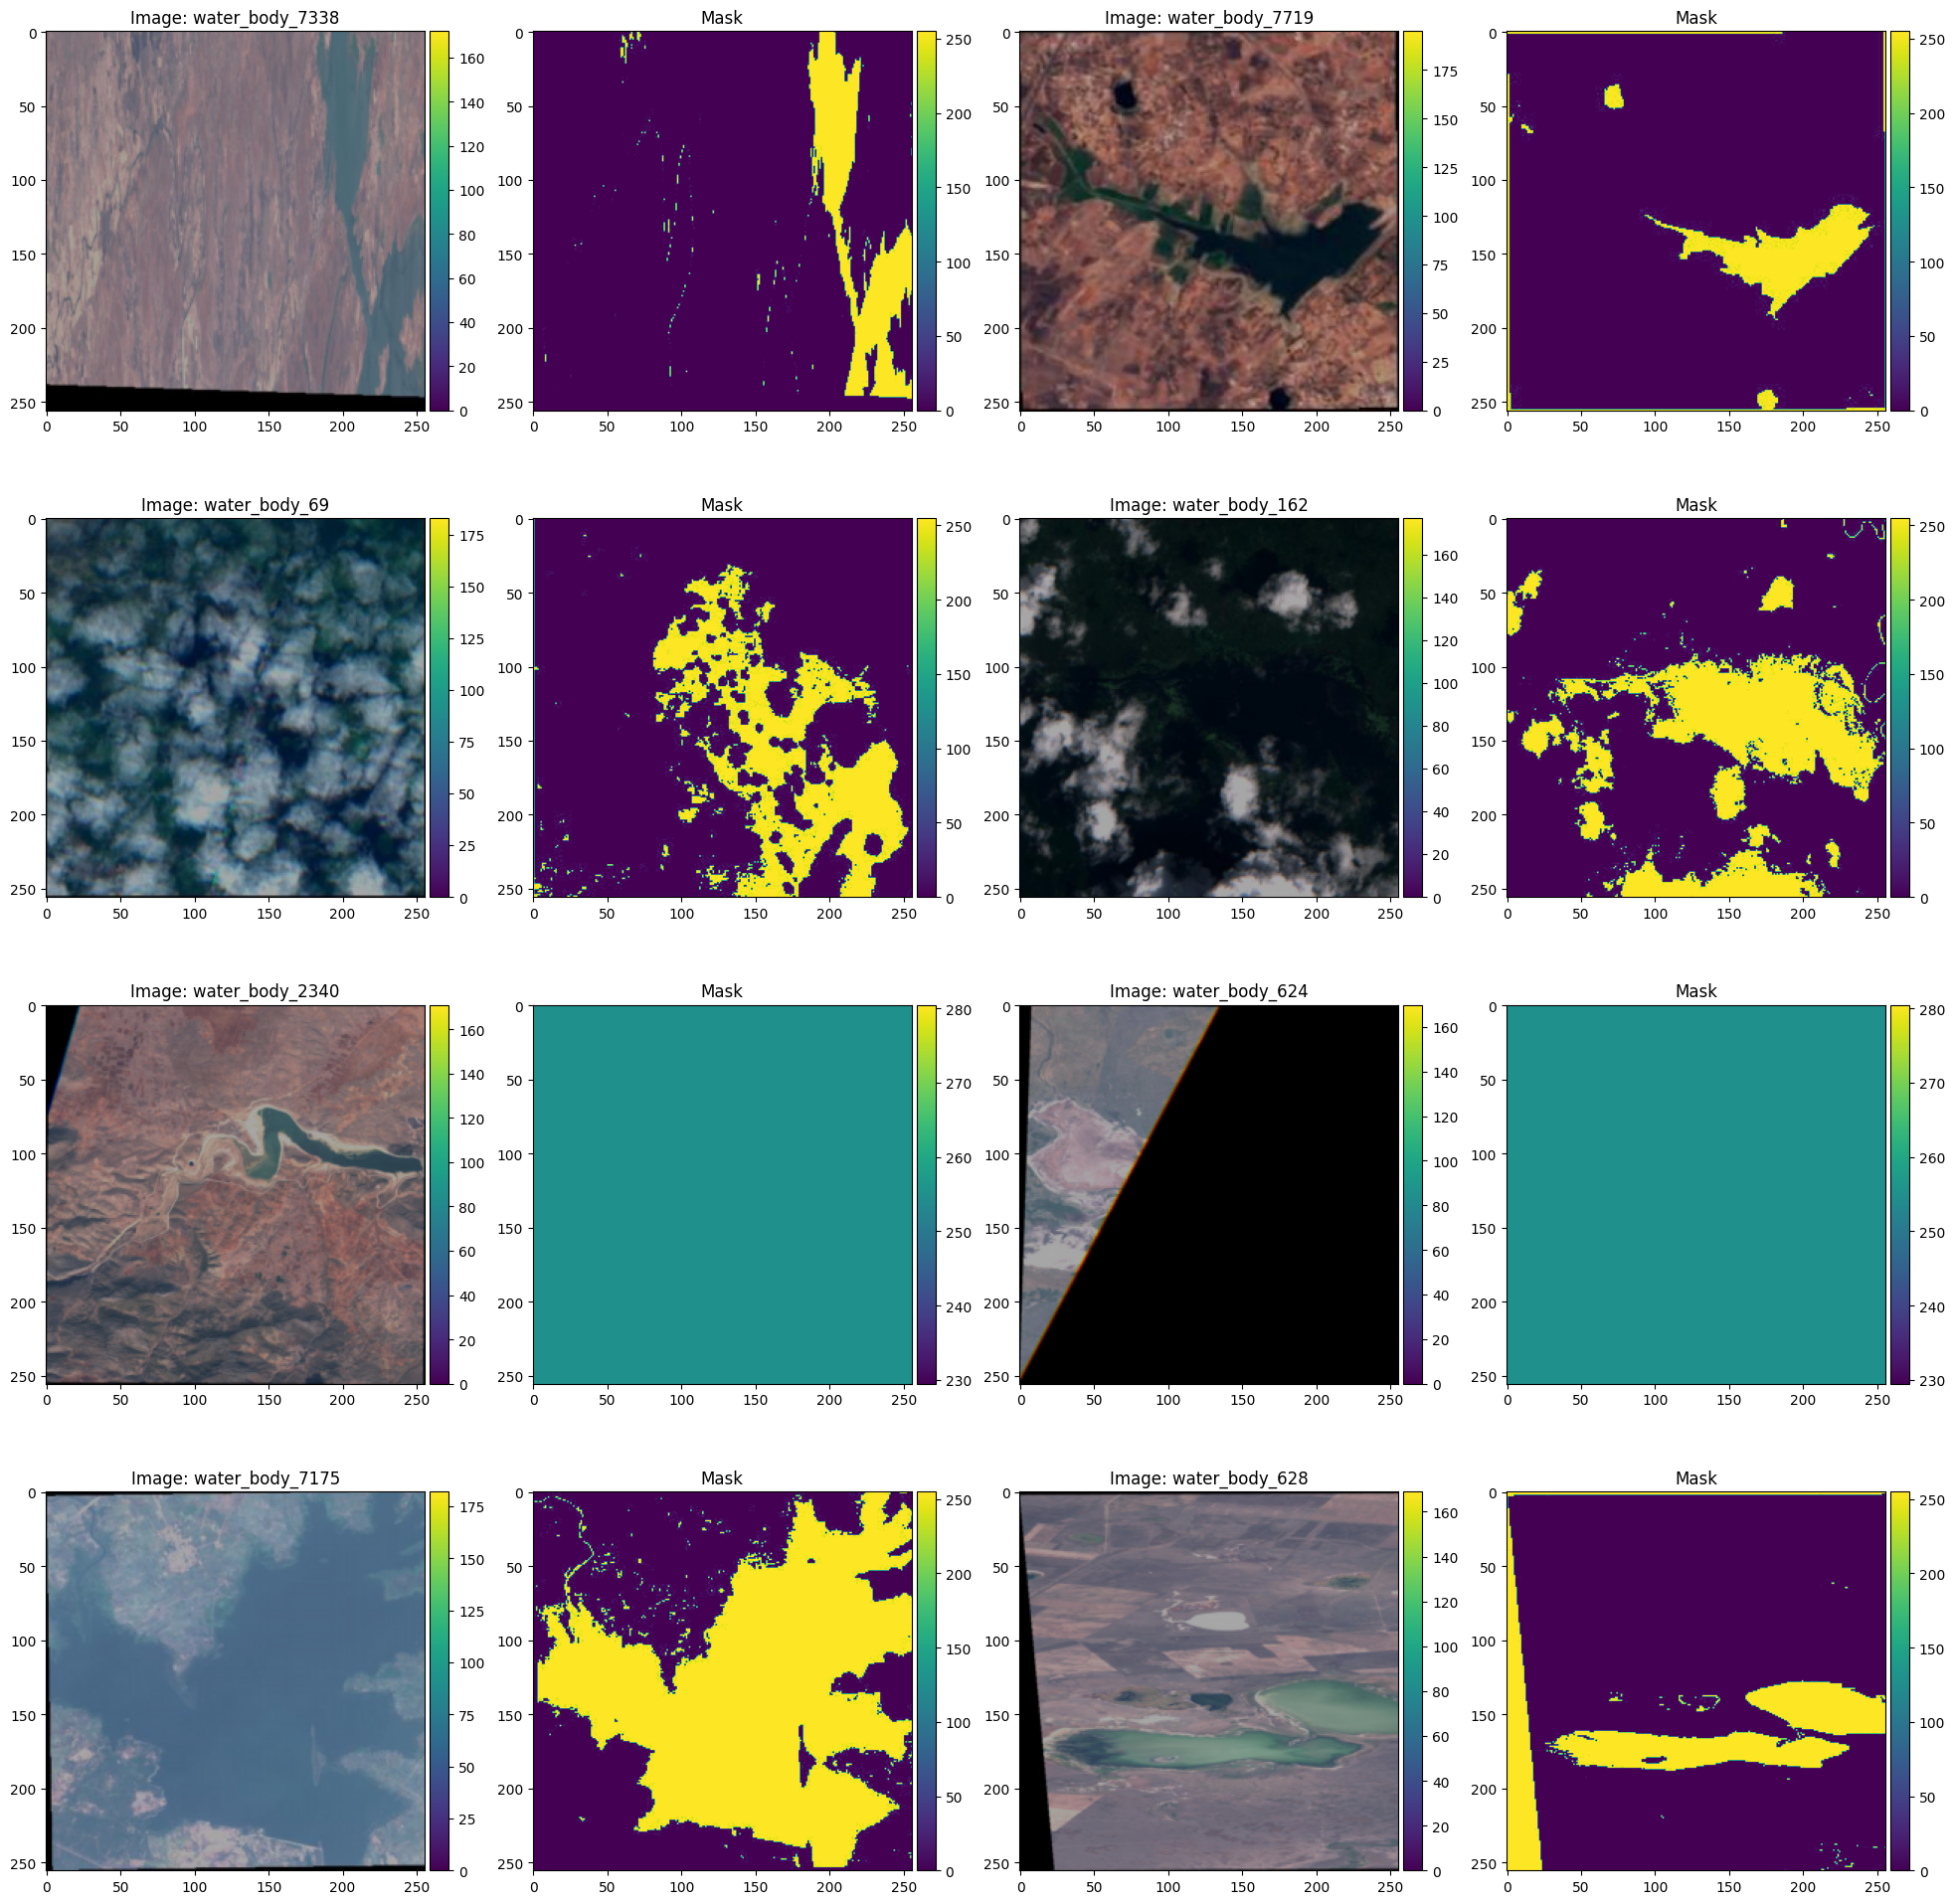

In [9]:
def reverse_transform(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    inp = (inp * 255).astype(np.uint8)
    return inp

def show_img_mask(im_name, img, mask, nrows, ncols, figsize):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    plt.tight_layout(pad=3.0)
    id_img = 0
    for i in range(nrows):
        for j in range(0, ncols, 2):
            ax1 = ax[i][j].imshow(reverse_transform(img[id_img]) )
            ax[i][j].set_title(f'Image: {im_name[id_img][:-4]}')           
            divider = make_axes_locatable(ax[i][j])
            cax = divider.append_axes("right", size="5%", pad=0.05)
            plt.colorbar(ax1, cax=cax)
            
            ax2 = ax[i][j+1].imshow( (mask[id_img][0].numpy() * 255).astype('uint8') )
            #ax[i][j+1].set_title(f'Mask: {im_name[id_img][:-4]}')
            ax[i][j+1].set_title(f'Mask')
            divider = make_axes_locatable(ax[i][j+1])
            cax = divider.append_axes("right", size="5%", pad=0.05)
            plt.colorbar(ax2, cax=cax)
            id_img += 1
                       
for im_name, image, mask in trainloader:
    show_img_mask(im_name, image, mask, 4, 4, figsize=(20, 20))
    break

## Model Building

In [10]:
# U-Net: Convolutional Networks for Biomedical Image Segmentation (2015)
class UNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()
        
        # Encoder
        # In the encoder, convolutional layers with the Conv2d function are used to extract features from the input image. 
        # Each block in the encoder consists of two convolutional layers followed by a max-pooling layer, with the exception of the last block which does not include a max-pooling layer.
        # -------
        # input: 572x572x3
        self.e11 = nn.Conv2d(3, 64, kernel_size=3, padding=1) # output: 570x570x64
        self.e12 = nn.Conv2d(64, 64, kernel_size=3, padding=1) # output: 568x568x64
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 284x284x64

        # input: 284x284x64
        self.e21 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # output: 282x282x128
        self.e22 = nn.Conv2d(128, 128, kernel_size=3, padding=1) # output: 280x280x128
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 140x140x128

        # input: 140x140x128
        self.e31 = nn.Conv2d(128, 256, kernel_size=3, padding=1) # output: 138x138x256
        self.e32 = nn.Conv2d(256, 256, kernel_size=3, padding=1) # output: 136x136x256
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 68x68x256

        # input: 68x68x256
        self.e41 = nn.Conv2d(256, 512, kernel_size=3, padding=1) # output: 66x66x512
        self.e42 = nn.Conv2d(512, 512, kernel_size=3, padding=1) # output: 64x64x512
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 32x32x512

        # input: 32x32x512
        self.e51 = nn.Conv2d(512, 1024, kernel_size=3, padding=1) # output: 30x30x1024
        self.e52 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1) # output: 28x28x1024


        # Decoder
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.d11 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.d12 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.d21 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.d22 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.d31 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.d32 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.d41 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.d42 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        # Output layer
        self.outconv = nn.Conv2d(64, n_class, kernel_size=1)
        
    def forward(self, x):
        # Encoder
        xe11 = relu(self.e11(x))
        xe12 = relu(self.e12(xe11))
        xp1 = self.pool1(xe12)

        xe21 = relu(self.e21(xp1))
        xe22 = relu(self.e22(xe21))
        xp2 = self.pool2(xe22)

        xe31 = relu(self.e31(xp2))
        xe32 = relu(self.e32(xe31))
        xp3 = self.pool3(xe32)

        xe41 = relu(self.e41(xp3))
        xe42 = relu(self.e42(xe41))
        xp4 = self.pool4(xe42)

        xe51 = relu(self.e51(xp4))
        xe52 = relu(self.e52(xe51))
        
        # Decoder
        xu1 = self.upconv1(xe52)
        xu11 = torch.cat([xu1, xe42], dim=1)
        xd11 = relu(self.d11(xu11))
        xd12 = relu(self.d12(xd11))

        xu2 = self.upconv2(xd12)
        xu22 = torch.cat([xu2, xe32], dim=1)
        xd21 = relu(self.d21(xu22))
        xd22 = relu(self.d22(xd21))

        xu3 = self.upconv3(xd22)
        xu33 = torch.cat([xu3, xe22], dim=1)
        xd31 = relu(self.d31(xu33))
        xd32 = relu(self.d32(xd31))

        xu4 = self.upconv4(xd32)
        xu44 = torch.cat([xu4, xe12], dim=1)
        xd41 = relu(self.d41(xu44))
        xd42 = relu(self.d42(xd41))

        # Output layer
        out = self.outconv(xd42)

        return out        
        

In [11]:
def dice_loss(pred, target, smooth=1.):
    pred = pred.contiguous()
    target = target.contiguous()

    intersection = (pred * target).sum(dim=2).sum(dim=2)

    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))

    return loss.mean()

def calc_loss(pred, target, metrics, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)

    pred = F.sigmoid(pred)
    dice = dice_loss(pred, target)

    loss = bce * bce_weight + dice * (1 - bce_weight)

    #metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    #metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)

    return loss


def print_metrics(metrics, epoch_samples, phase):
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))

    print("{}: {}".format(phase, ", ".join(outputs)), end = " | ")

def train_model(model, optimizer, scheduler, num_epochs=25):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10
    train_history = []
    val_history   = []
    best_epoch    = 1e10

    for epoch in range(num_epochs):
        print(f'Epoch {epoch:03d}/{(num_epochs - 1):03d}',end = " " )
        print(':','-' * 50, sep="")

        since = time.time()

        scheduler.step()
        #for param_group in optimizer.param_groups:
        #    print(f"[LR: {param_group['lr']}]")

        model.train()  

        metrics = defaultdict(float)
        epoch_samples = 0

        for _ , inputs, labels in trainloader:  
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                loss = calc_loss(outputs, labels, metrics)
                
                # backward + optimize only if in training phase
                loss.backward()
                optimizer.step()

            # statistics
            epoch_samples += inputs.size(0)

        print_metrics(metrics, epoch_samples, "Train") #phase)
        epoch_loss = metrics['loss'] / epoch_samples
        train_history.append((epoch, epoch_loss))
        
        ##########################################################       

        model.eval() 
        metrics = defaultdict(float)
        epoch_samples = 0

        for _ , inputs, labels in valloader:  
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            with torch.set_grad_enabled(False):
                outputs = model(inputs)
                loss = calc_loss(outputs, labels, metrics)
            # statistics
            epoch_samples += inputs.size(0)

        print_metrics(metrics, epoch_samples, "Val")  
        val_loss = metrics['loss'] / epoch_samples
        val_history.append((epoch, val_loss))

        ## deep copy the model
        if val_loss < best_loss:
            print("(val loss reduced)", end = " | ")
            best_epoch = epoch
            best_loss  = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, best_epoch, train_history, val_history
    

In [12]:
%%time
#num_class = 6
num_class = 1
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = UNet(num_class).to(device)

optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=30, gamma=0.1)

model, best_epoch, train_history, val_history = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs = 20) #45) 


Epoch 000/019 :--------------------------------------------------
Train: loss: 0.588887 | Val: loss: 0.510753 | (val loss reduced) | 0m 38s
Epoch 001/019 :--------------------------------------------------
Train: loss: 0.494604 | Val: loss: 0.487748 | (val loss reduced) | 0m 38s
Epoch 002/019 :--------------------------------------------------
Train: loss: 0.469186 | Val: loss: 0.431839 | (val loss reduced) | 0m 39s
Epoch 003/019 :--------------------------------------------------
Train: loss: 0.431142 | Val: loss: 0.436865 | 0m 38s
Epoch 004/019 :--------------------------------------------------
Train: loss: 0.417577 | Val: loss: 0.393922 | (val loss reduced) | 0m 39s
Epoch 005/019 :--------------------------------------------------
Train: loss: 0.389248 | Val: loss: 0.367687 | (val loss reduced) | 0m 39s
Epoch 006/019 :--------------------------------------------------
Train: loss: 0.364737 | Val: loss: 0.364737 | (val loss reduced) | 0m 40s
Epoch 007/019 :--------------------------

## Loss

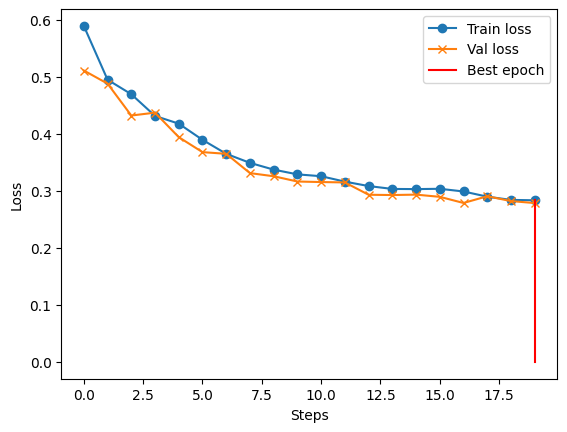

In [13]:
plt.plot([ a for (a, b) in train_history], [ b for (a, b) in train_history] , marker = 'o', label = "Train loss") 
plt.plot([ a for (a, b) in val_history], [ b for (a, b) in val_history] , marker = 'x', label = "Val loss")
plt.plot([ best_epoch, best_epoch], [ 0, val_history[best_epoch][1]+0.005 ] , color='red', label = "Best epoch")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend() 
plt.show()

## Test

In [14]:
for im_image , image, mask in testloader:
    global inputs, labels
    image = image.to(device)
    mask  = mask.to(device)

model.eval()   
pred = model(image)
pred = F.sigmoid(pred)
image_cpu = image.cpu()
mask_cpu  = mask.cpu().detach().numpy()
pred_cpu  = pred.cpu().detach().numpy()
images_rgb = [reverse_transform(x) for x in image_cpu  ]
print(image_cpu.shape, mask_cpu.shape, pred_cpu.shape)

torch.Size([12, 3, 256, 256]) (12, 1, 256, 256) (12, 1, 256, 256)


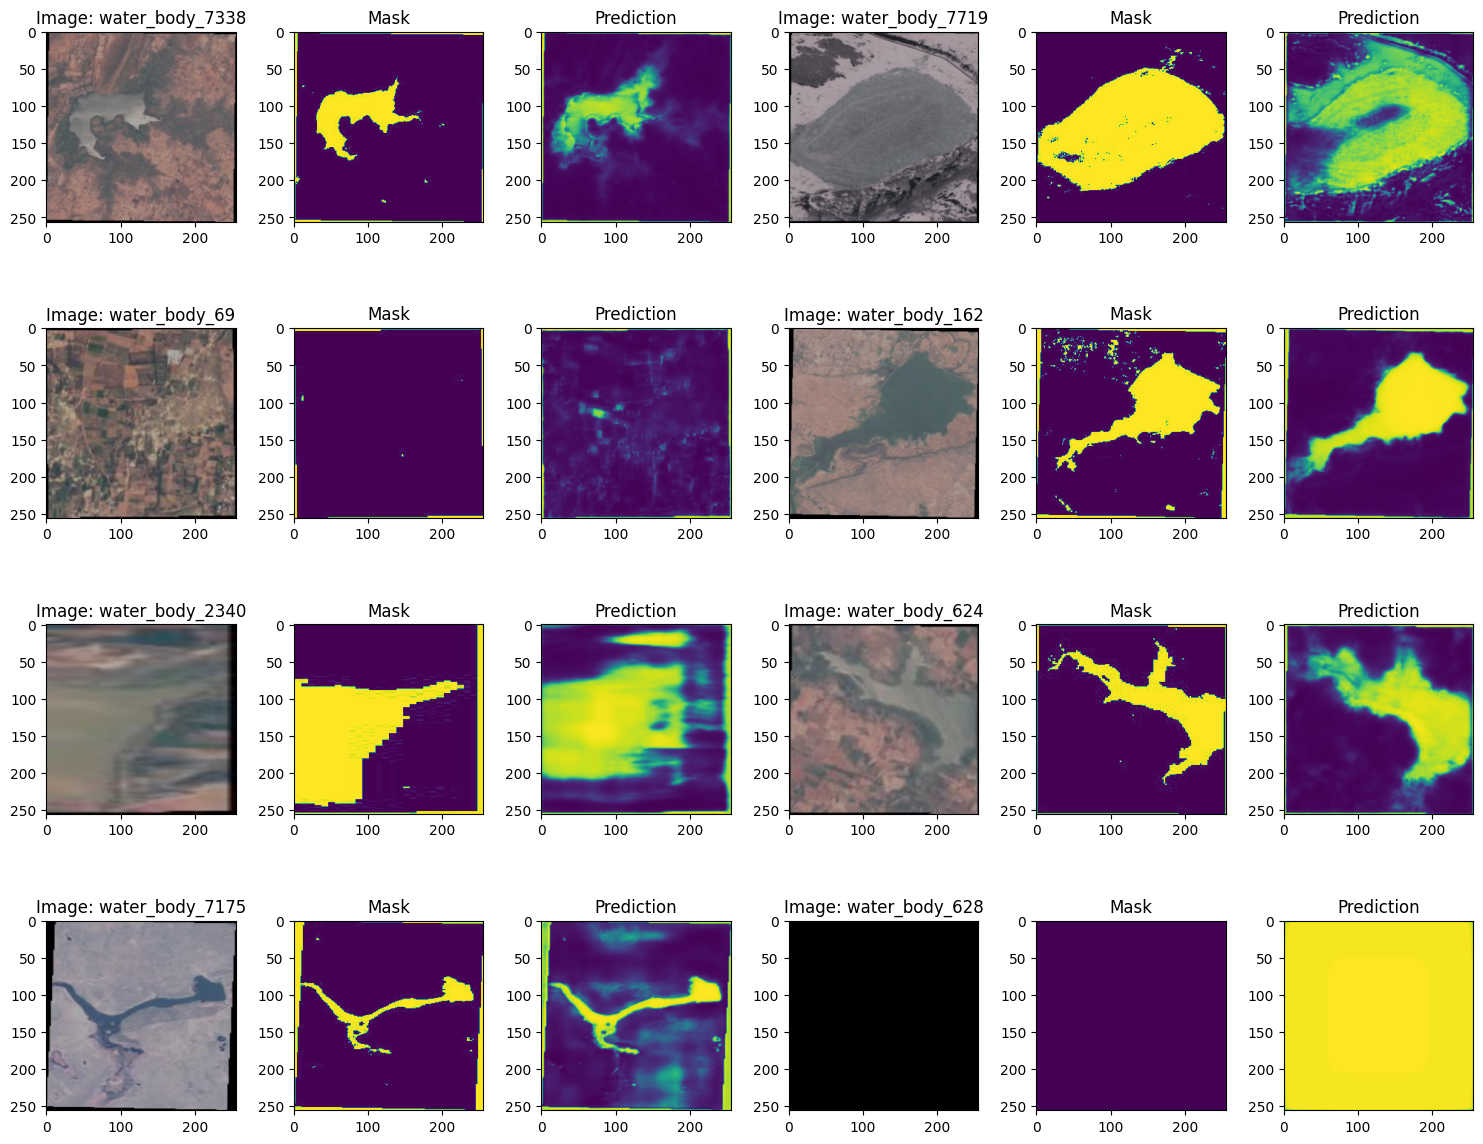

In [15]:
def show_img_mask_pred(img, mask, pred, nrows, ncols, figsize=(10, 15)):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    plt.tight_layout()
    id_img = 0
    for i in range(nrows):
        for j in range(0, ncols, 3):
            ax[i][j].imshow(img[id_img]  )
            ax[i][j].set_title(f'Image: {im_name[id_img][:-4]}') 
            ax[i][j+1].imshow( (mask[id_img] [0] * 255).astype('uint8') )
            ax[i][j+1].set_title(f'Mask')
            ax[i][j+2].imshow( (pred[id_img] [0] * 255).astype('uint8') )
            ax[i][j+2].set_title(f'Prediction')
            id_img += 1
show_img_mask_pred(images_rgb, mask_cpu, pred_cpu, 4, 6, figsize=(15, 12))